In [1]:
from display.display_figures import display_REstim, display_dataBuilt
from display.display_figures_by_county import display_comparison_uni_multi, display_comparison_error_uni_multi

from include.build_synth import buildData_fromRO as build
from include.build_synth import load_RO as load
from include.build_synth.Tikhonov_method import Tikhonov_spat_corr_config
from include.build_synth.compute_spatCorrLevels import compute_spatCorrLevels

from include.optim_tools.sliding_median import sliding_median

# For Rt estimation
from include.estim.Rt_MLE import Rt_MLE
from include.estim.Rt_Gamma import Rt_Gamma
from include.estim.Rt_Univariate import Rt_U
from include.estim.Rt_UnivariateOutliers import Rt_U_O
from include.estim.Rt_Multivariate import Rt_M

from include.comparison_tools.SNR import SignaltoNoiseRatio
from include.comparison_tools.jaccard_index import JaccardIndexREstim

## Building univariate synthetic infection counts

Building according to the chosen configuration and initial number of cases.
See `demo_buildSyntheticData.ipynb` for more detailed building synthetic data explanations.

In [2]:
configuration = 'I'  # Choice of configuration
firstCases = 100  # Choice of number of first cases on day one

# Loading realistic RDagger and ODagger
RDagger, ODagger = load.loadROconfig(configuration)

# Building synthetic data
ZDataBuilt, options = build.buildData_anyRO(RDagger, ODagger, firstCases)

# Cropping RDagger for further comparisons
RDaggerCrop = RDagger[1:];

C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:254: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


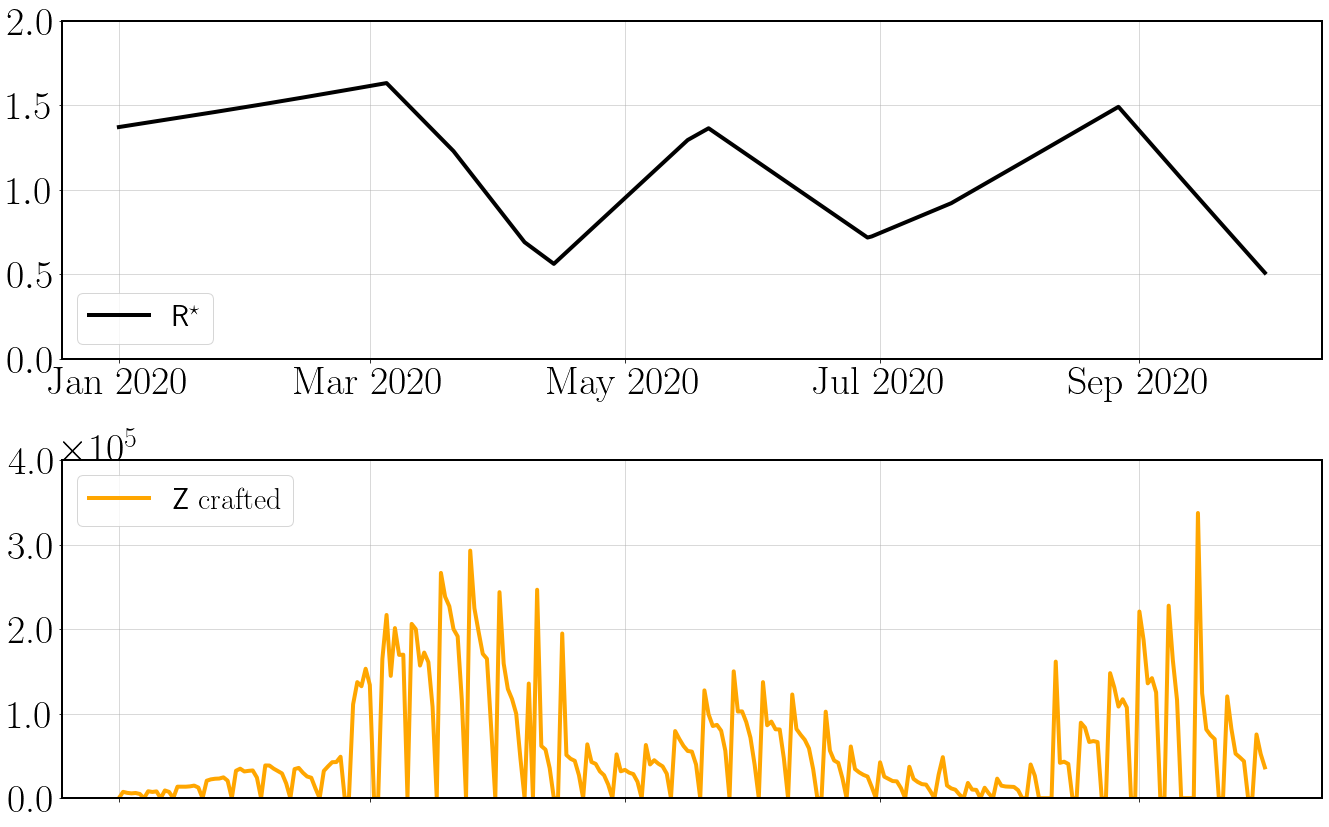

In [3]:
# Intermediate display of built data
display_dataBuilt(ZDataBuilt, RDagger, ODagger, options=options);

## Comparison between R estimation methods

### Signal-to-Ratio Noise (dB)

$\mathsf{SNR}:=  10 \times \log_{10}\left( \frac{\lVert  \boldsymbol{\mathsf{R}}^{\dagger}\rVert_2^2}{\lVert \widehat{\boldsymbol{\mathsf{R}}} - \boldsymbol{\mathsf{R}}^{\dagger} \rVert_2^2}\right)$

where $\widehat{\boldsymbol{\mathsf{R}}}$ is the estimated reproduction number with a chosen method, compared to ground truth $\boldsymbol{\mathsf{R}}^\dagger$.
### Jaccard index (%)

For $\boldsymbol{\mathsf{X}}, \boldsymbol{\mathsf{Y}} \in \lbrace 0, 1\rbrace^T, \, \,  \mathsf{Jac}^{\mathsf{g}}(\boldsymbol{\mathsf{X}},\boldsymbol{\mathsf{Y}}) := \frac{\sum_{t=1}^T \sqrt{\mathsf{X}^{\mathsf{g}}_t \times \mathsf{Y}^{\mathsf{g}}_t}}{\sum_{t=1}^T \mathsf{X}^{\mathsf{g}}_t + \mathsf{Y}^{\mathsf{g}}_t - \sqrt{\mathsf{X}^{\mathsf{g}}_t \times \mathsf{Y}^{\mathsf{g}}_t}}$

where $\mathsf{X}^{\mathsf{g}}$ (resp. $\mathsf{Y}^{\mathsf{g}}$) is the convolution between the binary vector $\boldsymbol{\mathsf{X}}$ (resp. $\boldsymbol{\mathsf{Y}}$) and a Gaussian distribution.
(see [include/comparison_tools/jaccard_index.py](include/comparison_tools/jaccard_index.py) for more details)

### Maximum Likelihood Estimator
$$ \widehat{\mathsf{R}}_t^{\mathsf{MLE}} = \frac{\mathsf{Z}_t}{\Phi^{\boldsymbol{\mathsf{Z}}}_{t}} $$

In [4]:
# Analytic computation
R_MLE, options_MLE = Rt_MLE(ZDataBuilt, options)

Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---


In [5]:
# Computing SNR and Jaccard index
print('MLE performance indicators ---')
SNR_MLE = SignaltoNoiseRatio(RDaggerCrop, R_MLE)
JaccardIndexMLE = JaccardIndexREstim(RDaggerCrop, R_MLE)
print("SNR = %.3f dB, associated Jaccard index = %.3f %%" % (SNR_MLE, JaccardIndexMLE))

MLE performance indicators ---
SNR = 0.326 dB, associated Jaccard index = 0.758 %


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


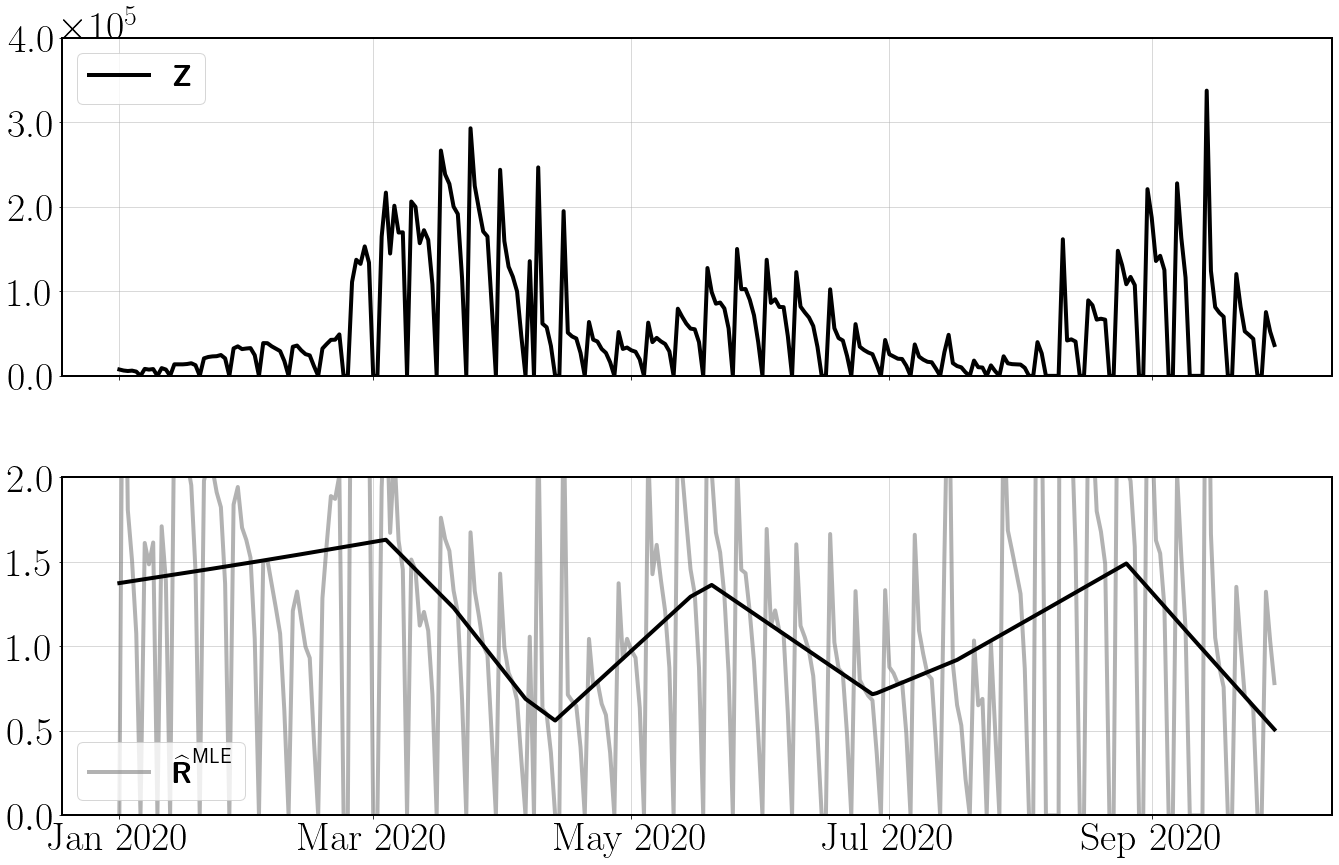

In [6]:
# Individual display
display_REstim(R_MLE, RTrue=RDagger, options=options_MLE);

### Bayesian Estimator

$$\widehat{\mathsf{R}}_t^\Gamma = \frac{1 + \sum_{s=t-\tau}^{t}\mathsf{Z}_s}{5 + \sum_{s=t-\tau}^{t}\Phi^{\boldsymbol{\mathsf{Z}}}_{s}}$$


In [7]:
# Choice of the hyperparameter
tau = 15

# Analytic computation
R_Gamma, options_Gamma = Rt_Gamma(ZDataBuilt, tau=tau, options=options)

Computing Bayesian estimator ...
Done in 0.0000 seconds ---


In [8]:
# Computing SNR and Jaccard index
print('Bayesian estimator performance indicators ---')
SNR_Gamma = SignaltoNoiseRatio(RDaggerCrop, R_Gamma)
JaccardIndexGamma = JaccardIndexREstim(RDaggerCrop, R_Gamma)
print("SNR = %.3f dB, associated Jaccard index = %.3f %%" % (SNR_Gamma, JaccardIndexGamma))

Bayesian estimator performance indicators ---
SNR = 7.344 dB, associated Jaccard index = 2.639 %


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


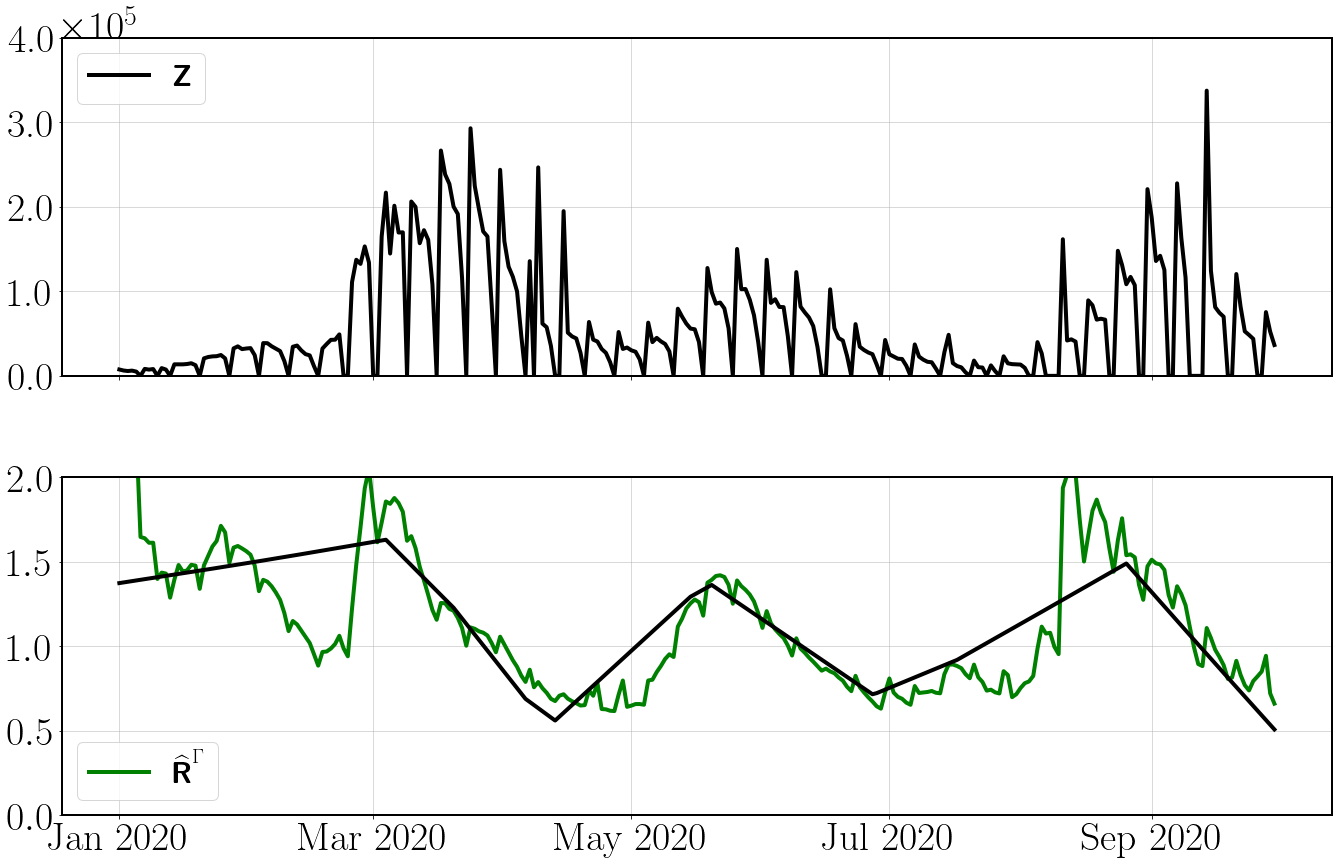

In [9]:
# Individual display
display_REstim(R_Gamma, RTrue=RDagger, options=options_Gamma);

### Univariate estimation

1. $\mathsf{Z}^{(\alpha)} =$ `sliding_median`$(\mathsf{Z}; \alpha)$
    &nbsp;

2. $ \widehat{\boldsymbol{\mathsf{R}}}^{\mathsf{U}} = \underset{\boldsymbol{\mathsf{R}} \in \mathbb{R}_+^{ T}}{\mathrm{argmin}} \,\mathrm{D}_{\mathsf{KL}}(\boldsymbol{\mathsf{Z}}^{(\alpha)} | \boldsymbol{\mathsf{p}}) + \lambda_{\mathsf{L}}^{\mathsf{U}} \lVert \mathsf{L} \boldsymbol{\mathsf{R}}\rVert_1 , \quad \mathsf{p}_t = \mathsf{R}_t \Phi^{\boldsymbol{\mathsf{Z}}}_t$

In [10]:
# Choice of denoising parameter alpha and regularization parameter muR
alpha = 0.1
lambdaU_L = 50

# Denoising with sliding median then solving with Chambolle-Pock algorithm
Z_alpha = sliding_median(ZDataBuilt, alpha)
R_U, options_U = Rt_U(Z_alpha, lambdaU_L, options=options)

Computing Univariate estimator ...
Done in 5.7396 seconds ---


In [11]:
# Computing SNR and Jaccard index
print('Univariate estimator performance indicators ---')
SNR_U = SignaltoNoiseRatio(RDaggerCrop, R_U)
JaccardIndexU = JaccardIndexREstim(RDaggerCrop, R_U)
print("SNR = %.3f dB, associated Jaccard index = %.3f %%" % (SNR_U, JaccardIndexU))

Univariate estimator performance indicators ---
SNR = 18.942 dB, associated Jaccard index = 10.124 %


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


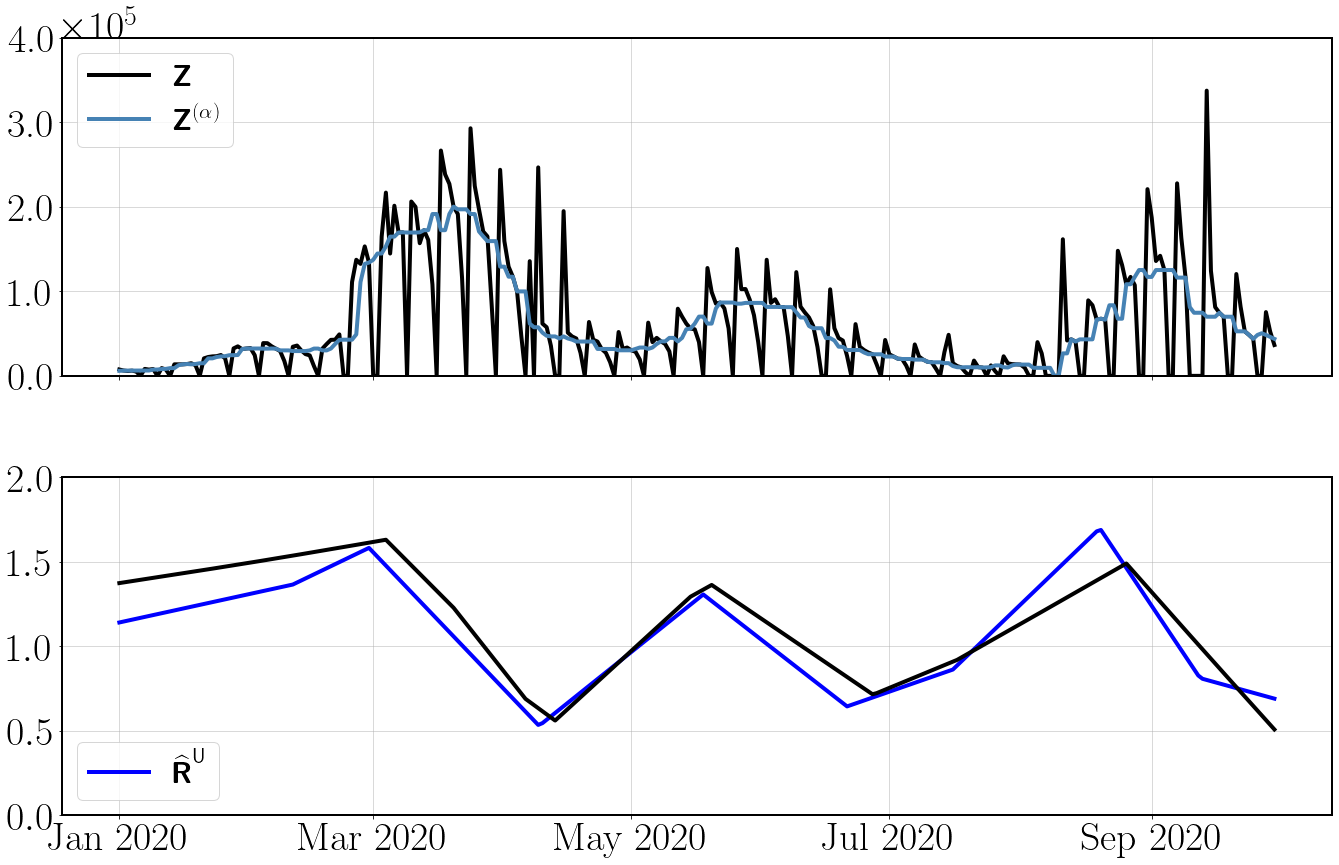

In [12]:
# Individual display
display_REstim(R_U, RTrue=RDagger, options=options_U);

### Univariate reproduction number estimator including misreported counts correction

$$\widehat{\boldsymbol{\mathsf{R}}}^{\mathsf{U-O}}, \widehat{\boldsymbol{\mathsf{O}}}^{\mathsf{U-O}} = \, \underset{\boldsymbol{\mathsf{R}} \in \mathbb{R}_+^{ T}, \boldsymbol{\mathsf{O}} \in \mathbb{R}^{ T}}{\mathrm{argmin}} \,\mathrm{D}_{\mathsf{KL}}(\boldsymbol{\mathsf{Z}} | \boldsymbol{\mathsf{p}}) + \lambda_{\mathsf{L}}^{\mathsf{U}} \lVert \mathsf{L} \boldsymbol{\mathsf{R}}\rVert_1 + \lambda_\mathsf{O}^\mathsf{U} \lVert \mathsf{O}\rVert_1 , \quad \mathsf{p}_t = \mathsf{R}_t \Phi^{\boldsymbol{\mathsf{Z}}}_t$$

In [13]:
# Choice of denoising parameter alpha and regularization parameter muR
lambdaR = 3.5
lambdaO = 0.03

# Solving with Chambolle-Pock algorithm
R_UO, O_UO, options_UO = Rt_U_O(ZDataBuilt, lambdaR=lambdaR, lambdaO=lambdaO, options=options)


Computing Univariate estimation with O misreported counts modelisation ...
iter 100000.000000 	 crit=3.942123 

Done in 52.0299 seconds ---


In [14]:
# Computing SNR and Jaccard index
print('Univariate estimator including misreported counts performance indicators ---')
SNR_UO = SignaltoNoiseRatio(RDaggerCrop, R_UO)
JaccardIndexUO = JaccardIndexREstim(RDaggerCrop, R_UO)
print("SNR = %.3f dB, associated Jaccard index = %.3f %%" % (SNR_UO, JaccardIndexUO))

Univariate estimator including misreported counts performance indicators ---
SNR = 32.308 dB, associated Jaccard index = 78.771 %


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


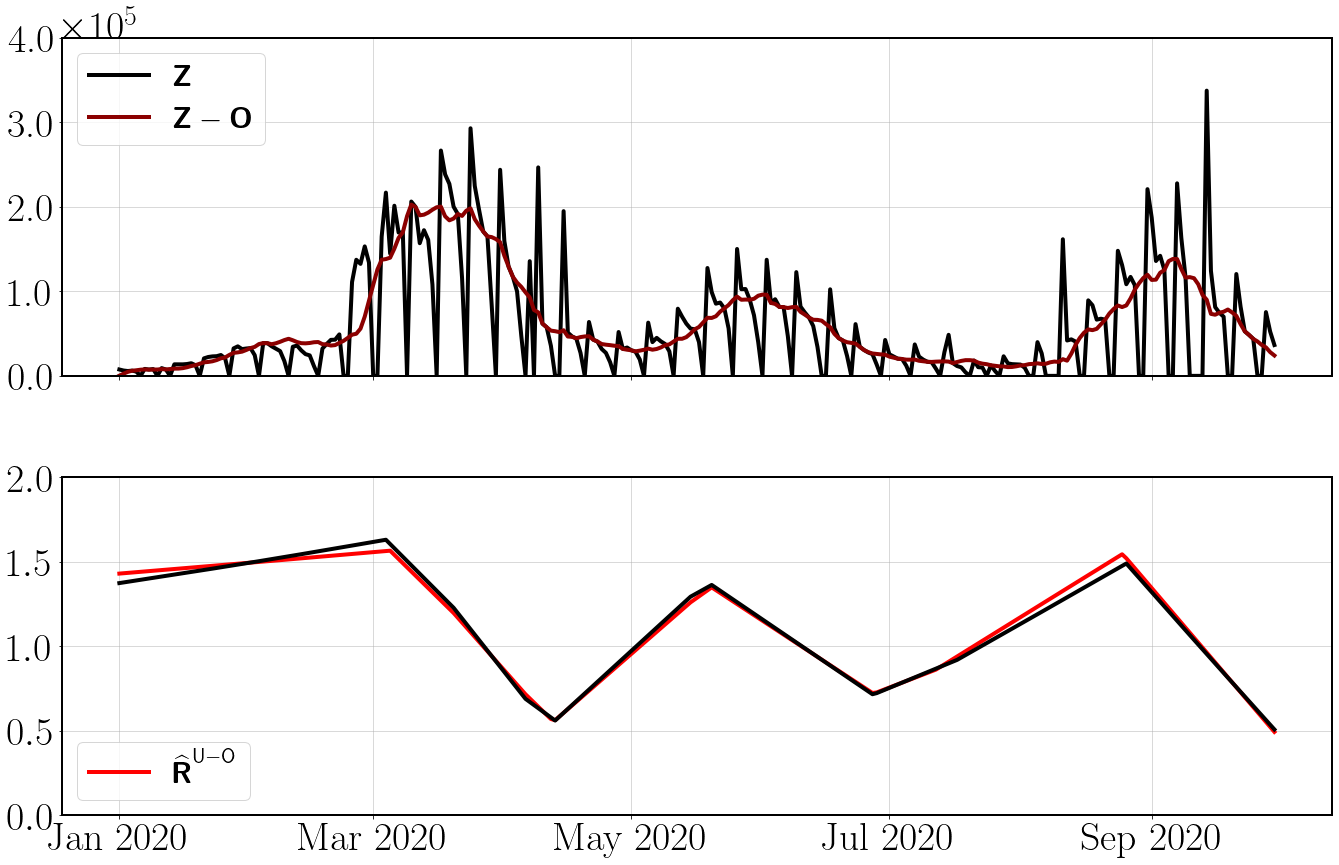

In [15]:
# Individual display
display_REstim(R_UO, RTrue=RDagger, options=options_UO);

### Summary of univariate estimations

C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


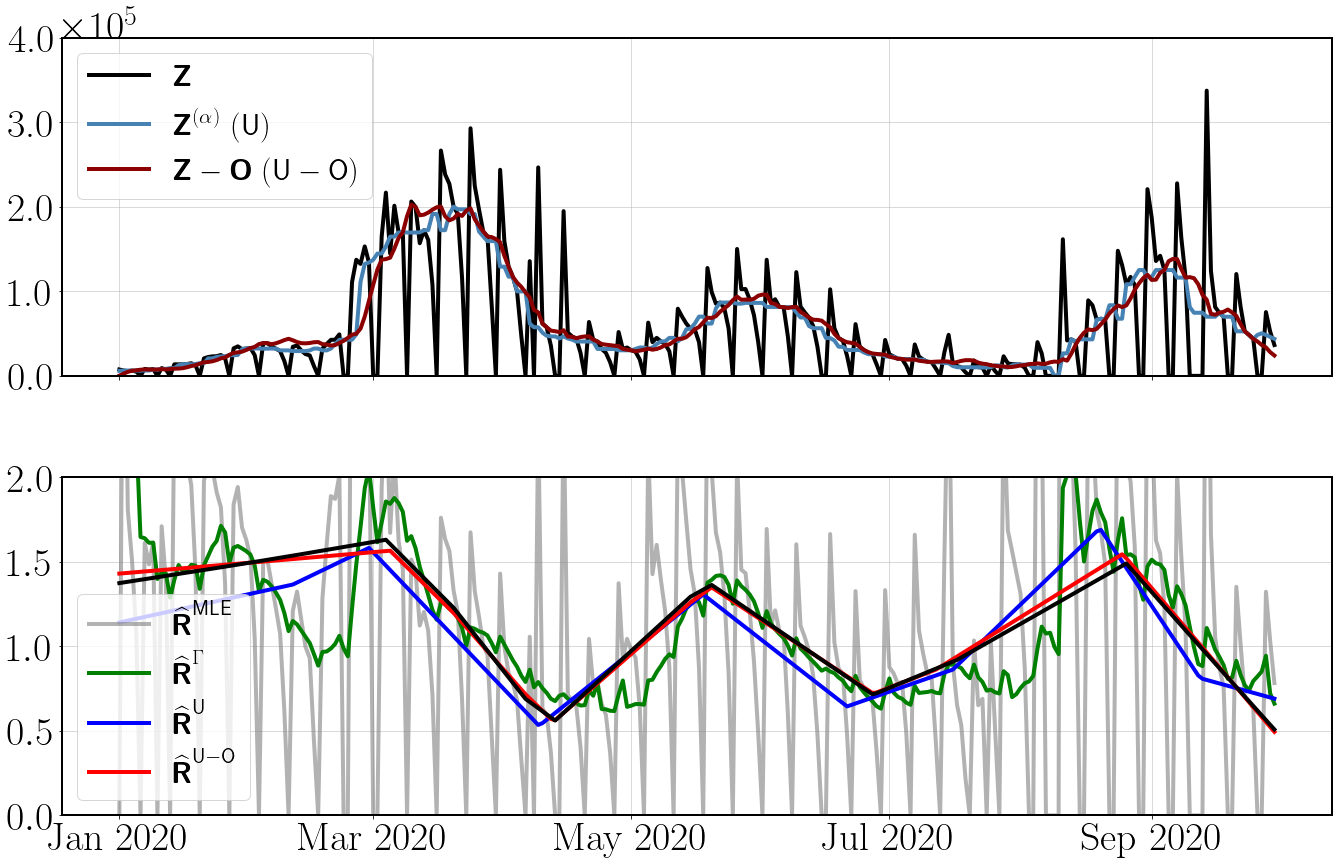

In [16]:
# Gather all methods
REstimations = {'MLE': R_MLE, 'Gamma': R_Gamma, 'U': R_U, 'U-O': R_UO}
optionsAll = {'MLE': options_MLE, 'Gamma': options_Gamma, 'U': options_U, 'U-O': options_UO}

# Display comparison between methods
display_REstim(REstimations, optionsAll, RTrue=RDagger, comparison=True);

## Multivariate/univariate performances comparison

### Performances quantitative tools
* Mean Square Error for multivariate counts: a smaller value means better performance

    $$\mathsf{MSE} := \frac{1}{C} \sum_{c=1}^C  \frac{\sum_{t = 1}^T \left( \widehat{\mathsf{R}}_{c, t} - \mathsf{R}^\star_{c, t} \right)^2}{\sum_{t = 1}^T \left(\mathsf{R}^\star_{c, t}\right)^2}$$

* Signal-to-Ratio Noise (dB): a greater value means better performance

    $$\mathsf{SNR}:=  10 \times \log_{10}\left( \frac{\lVert  \boldsymbol{\mathsf{R}}^{\star}\rVert_2^2}{\lVert \widehat{\boldsymbol{\mathsf{R}}} - \boldsymbol{\mathsf{R}}^{\star} \rVert_2^2}\right)$$

* Jaccard index (%) averaged on counties: a greater value means better performance

    $$\forall \,\, \boldsymbol{\mathsf{X}}, \boldsymbol{\mathsf{Y}} \in \lbrace 0, 1\rbrace^T, \, \,  \mathsf{Jac}^{\mathsf{g}}(\boldsymbol{\mathsf{X}},\boldsymbol{\mathsf{Y}}) := \frac{\sum_{t=1}^T \sqrt{\mathsf{X}^{\mathsf{g}}_t \times \mathsf{Y}^{\mathsf{g}}_t}}{\sum_{t=1}^T \mathsf{X}^{\mathsf{g}}_t + \mathsf{Y}^{\mathsf{g}}_t - \sqrt{\mathsf{X}^{\mathsf{g}}_t \times \mathsf{Y}^{\mathsf{g}}_t}}$$

In [17]:
from include.comparison_tools.jaccard_index import JaccardIndexAveraged
from include.comparison_tools.MSE import MSEMeanNorm

### Spatially correlated reproduction number ground truth
Crafting spatially correlated $\boldsymbol{\mathsf{R}}^\star$ using $\boldsymbol{\mathsf{R}}^\dagger$ and inter-county correlation level $\delta$:

$$\boldsymbol{\mathsf{R}}^\star (\boldsymbol{\mathsf{R}}^\dagger; \delta) = \underset{\boldsymbol{\mathsf{R}} \in \mathbb{R}^{C\times T}}{\mathrm{argmin}} \, \lVert \boldsymbol{\mathsf{R}}^\dagger - \boldsymbol{\mathsf{R}}\rVert_2^2 +  \delta  \lVert \mathsf{G} \boldsymbol{\mathsf{R}}\rVert_2^2$$

In [18]:
# Choice of connectivity structure and spatial correlation level (configMulti) for multivariate synthetic infection counts
connectStruct = 'Line'  # or 'Hub'

# Loading R dagger = R_by_county and O dagger = O_by_county, crafted on each county.
R_by_county, O_by_county, optionsMulti = load.loadROconfigMulti(connectStruct, '0')

# Computing inter-county correlation levels
optionsDelta = compute_spatCorrLevels(R_by_county, options=optionsMulti, fileSuffix=connectStruct)

# Adding inter-county correlations to R_by_county (or R_dagger)
configMulti = 'IV'
R_star = Tikhonov_spat_corr_config(R_by_county, configMulti, optionsDelta)

# Crafting synthetic infection counts using R_spat_corr (or R star)
ZDataBuiltMulti, optionsBuiltMulti = build.buildDataMulti_anyRO(R_star, O_by_county, options=optionsMulti)

### Univariate estimation (by county)
$$ \widehat{\boldsymbol{\mathsf{R}}}^{\mathsf{U}} = \, \underset{\boldsymbol{\mathsf{R}} \in \mathbb{R}_+^{ T}}{\mathrm{argmin}} \,\mathrm{D}_{\mathsf{KL}}(\boldsymbol{\mathsf{Z}} | \boldsymbol{\mathsf{p}}) + \lambda_{\mathsf{L}}^{\mathsf{U}} \lVert \mathsf{L} \boldsymbol{\mathsf{R}}\rVert_1 , \quad \mathsf{p}_t = \mathsf{R}_t \Phi^{\boldsymbol{\mathsf{Z}}}_t$$

In [19]:
lambdaU_L = 50
R_uni, options_U = Rt_U(ZDataBuiltMulti, lambdaU_L, options=optionsBuiltMulti)

Computing Univariate estimator ...
Done in 4.8247 seconds ---


In [20]:
# Computing performances quantities ---
print('Univariate estimator performance indicators ---')
MSE_uni = MSEMeanNorm(R_star[:, 1:], R_uni) * 100  # for displaying purposes
SNR_uni = SignaltoNoiseRatio(R_star[:, 1:], R_uni)
JaccardIndex_uni = JaccardIndexAveraged(R_star[:, 1:], R_uni)
print("MSE x 100 = %.3f (to minimize)\nSNR = %.2f dB (to maximize)\nAssociated Jaccard index = %.2f %%" % (MSE_uni, SNR_uni, JaccardIndex_uni))

Univariate estimator performance indicators ---
MSE x 100 = 0.464 (to minimize)
SNR = 23.33 dB (to maximize)
Associated Jaccard index = 44.80 %


### Multivariate estimation

$$ \widehat{\boldsymbol{\mathsf{R}}}^{\mathsf{M}} = \, \underset{\boldsymbol{\mathsf{R}} \in \mathbb{R}_+^{C\times T}}{\mathrm{argmin}} \,\mathrm{D}_{\mathsf{KL}}(\boldsymbol{\mathsf{Z}} | \boldsymbol{\mathsf{p}}) + \lambda_{\mathsf{L}}^{\mathsf{M}} \lVert \mathsf{L} \boldsymbol{\mathsf{R}}\rVert_1 + \lambda_{\mathsf{G}}^{\mathsf{M}} \lVert \mathsf{G} \boldsymbol{\mathsf{R}}\rVert_1, \quad \mathsf{p}_t = \mathsf{R}_t \Phi^{\boldsymbol{\mathsf{Z}}}_t$$

In [21]:
lambdaM_L = 50
lambdaM_G = 0.005
R_multi, options_M = Rt_M(ZDataBuiltMulti, lambdaM_L, lambdaM_G, options=optionsBuiltMulti)

Computing Multivariate estimator ...
iter 100000.000000 	 crit=101.955633 

Done in 55.5178 seconds ---


In [22]:
# Computing performances quantities ---
print('Multivariate estimator performance indicators ---')
MSE_multi = MSEMeanNorm(R_star[:, 1:], R_multi) * 100  # for displaying purposes
SNR_multi = SignaltoNoiseRatio(R_star[:, 1:], R_multi)
JaccardIndex_multi = JaccardIndexAveraged(R_star[:, 1:], R_multi)
print("MSE x 100 = %.3f (to minimize)\nSNR = %.2f dB (to maximize)\nAssociated Jaccard index = %.2f %%" % (MSE_multi, SNR_multi, JaccardIndex_multi))

Multivariate estimator performance indicators ---
MSE x 100 = 0.306 (to minimize)
SNR = 25.14 dB (to maximize)
Associated Jaccard index = 46.31 %


### Comparison between Univariate and Multivariate estimation on multivariate spatially correlated infection counts

C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures_by_county.py:220: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures_by_county.py:283: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


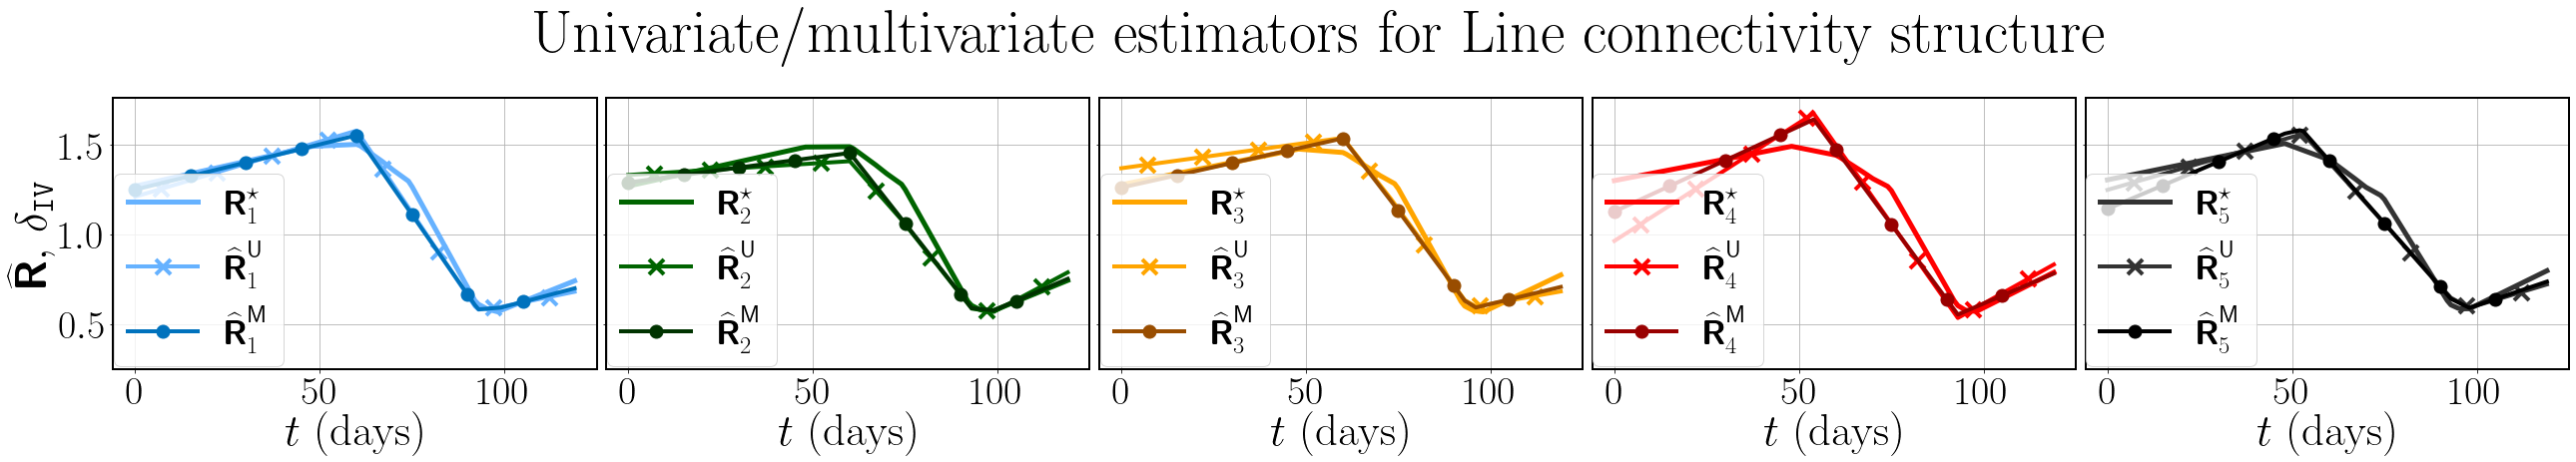

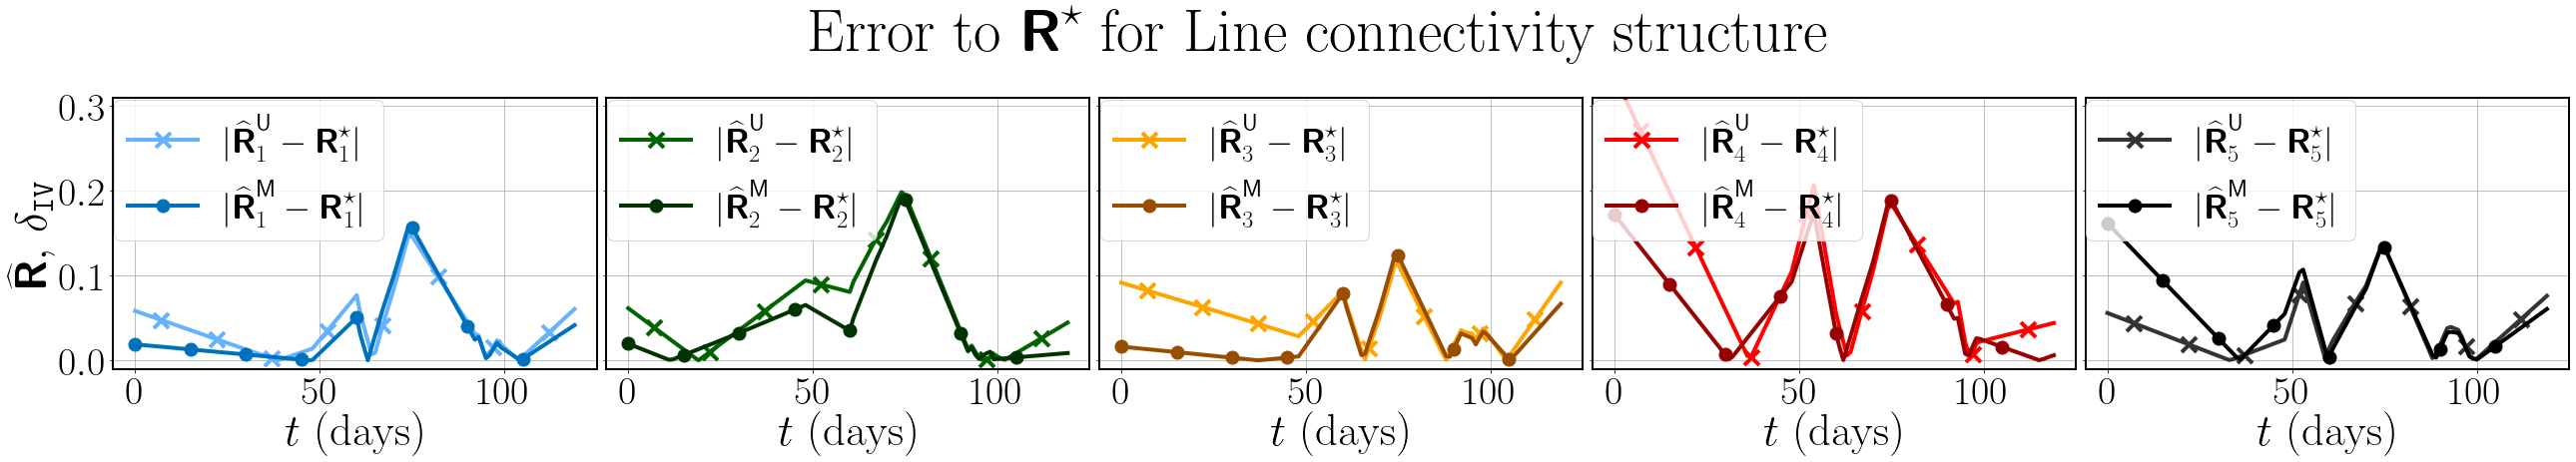

In [23]:
# Displaying comparison for chosen crafted infection counts, with chosen inter-county correlation level
display_comparison_uni_multi(connectStruct, configMulti, R_star, R_uni, R_multi)
display_comparison_error_uni_multi(connectStruct, configMulti, R_star, R_uni, R_multi)